# SEP Forecasting - Logisitic Regression
***

Current physics based models of SEPs are unable to execute sufficiently fast in order to
provide actionable information towards forecasting such disturbances, which can impact
Earth within tens of minutes of the onset of an eruptive event. This is compounded by
the intrinsic latency of certain key observations, which are used to define the initial
conditions of these models. Instead, there is a reliance on statistical models to provide
forecast probabilities of Earth-bound SEPs using real-time data. Since the largest, most
impactful events occur infrequently, some regions of the feature space are sparse and
simple discrete binning procedures have limitations. The goal of this project is to
improve upon the empirical SEP proton prediction forecast model (PROTONS) currently
in operational use at SWPC, through the application of modern machine learning
techniques.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from datetime import datetime,timedelta

from pandas.plotting import scatter_matrix

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, recall_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, roc_curve, brier_score_loss, precision_score
from sklearn.metrics import brier_score_loss as bsl
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
#import scikitplot as skplt


from scipy.sparse import csr_matrix, find


### Read in and format the original Balch 2008 event list 

Choice of files: 

SPEall.v7p.xls - original SEP (only) event list from Balch 2008  
ctrlevents.v8p.xls - original event list (SEP + control) from Balch 2008  
ControlEvents_student.xls - Balch 2008 (SEP + control) event list with added CME speed and GOES T and EM from Dougs student

In [8]:
#read in the original Balch SEP event list with added CME speed and GOES T and EM
#orig_data = pd.read_excel("ControlEvents_student.xls")

#adding y label column indicating positive and negative SEP events - SEP events have Association = ProtonFlare
#orig_data['sep'] = orig_data.Association.str.contains('^Proton').astype(int)

#convert the type II and type IV association to binary 
#orig_data.TypeII = (orig_data.TypeII.str.lower() == "yes").astype(int)
#orig_data.TypeIV = (orig_data.TypeIV.str.lower() == "yes").astype(int)

# Remove rows where optlocation = nan
#orig_data = orig_data[orig_data.optlocation.astype('str') != 'nan']

#shuffle the events so they are not organized 
#orig_data = shuffle(orig_data)

#save the shuffled dataframe -- commented out to prevent resaving
#orig_data.to_csv("AllEvtsShuffled_1986_2004_cme.csv")


### Read in the new SEP events from 2004 onwards

Created by Pedro Brae

In [ ]:
#read in the SEP event list from 2004 - 2017
#new_data = pd.read_csv('sep_events_2004_2017.csv')


### Original Balch Features

From the original Balch 1999 and 2008 paper analysis only 4 features were used. GOES flare peak soft X-ray peak (1-8 A channel), flare soft X-ray integrated flux, occurrence of Type II and Type IV radio bursts.

In [2]:
class BalchPaperFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        """Class to create original 4 features from Balch 2008"""
        
        return None
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        
        return ['FlrPeakFlux','FlrIntFlux','TypeII','TypeIV']
    
    def transform(self, examples):
                
        #Choose the orginal 4 Balch 2008 features
        X = examples[['FlrPeakFlux','FlrIntFlux2','TypeII','TypeIV']]
        
        return(X)

### Raw features

Other features read directly from the original event list i.e. the flare integrated soft X-ray flux at the GOES short wavelength channel (0.5 - 1 A), the GOES temperature and GOES emission measure

In [3]:
class RawFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        """Other features from the Event List that don't need to be manipulated before being included in model"""
        
        return None
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        
        return ['FlrIntFlux','tchianti','emchianti']
    
    def transform(self, examples):
                
        #Choose the orginal 4 Balch 2008 features (5 if you include both type II and type Iv as separate features)
        X = examples[['FlrIntFlux','tchianti','emchianti']]

        return(X)

### Flare time to peak

The time between the flare onset and the flare peak time

In [26]:
class FlareTime2Peak(BaseEstimator, TransformerMixin):
    
    """Class to create feature with the time between flare onset to flare max time"""
    
    def __init__(self):
        
        return None
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        
        return ["FlTim2Pk"]|
    
    def transform(self, examples):
        
        # Initiaize matrix 
        X = np.zeros((len(examples),1))           

        #time between flare max and flare onset
        X[:,0] = np.asarray([(mx - on).seconds for mx, on in zip(examples.Flrmaxtime, examples.FlrOnset)])
        
        return(X)

### Flare location

The flare location formatted from N16W12 format to North-South and East-West of disk center values

In [5]:
class LocationFeatures(BaseEstimator, TransformerMixin):
   
    """Class to create feature with the time between flare onset to flare max time"""
   
    def __init__(self):
       
        return None
   
    def fit(self, examples):
        # return self and nothing else 
        return self
   
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
       
        return ['Loc']
   
    def transform(self, examples):
       
        # Initiaize matrix 
        X = np.zeros((len(examples),2))  
       
        #time between flare max and flare onset
        #X[:,0] = np.asarray([str(x)[1:3] for x in examples.optlocation])   #north - south
        #X[:,1] = np.asarray([str(x)[4::] for x in examples.optlocation])   #north - south
       
        for i,loc in enumerate(examples.optlocation):
            lat = str(loc)[1:3]
            if str(loc)[0] == 's' or str(loc)[0] == 'S':
                X[i,0] = -int(lat)
            else:
                X[i,0] = (lat)

            #west-east
            long = str(loc)[4::]
            if str(loc)[3] == 'w' or str(loc)[3] == 'W':
                X[i,1] = -int(long)
            else:
                X[i,1] = int(long)

        return(X)

### SEP Class 

With functions to build the training feature list from the above feature extractors

In [20]:
class SEPClass(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator, folds = 6, threshold=0.5):        # <--- other keywords to be used by Feature Union go here
        
        """Class to fit and train Logistic Regression algorithm for SEP forecasting
        
        Input keywords:
        
        folds:        Number of cross validation folds to use
        threshold:    Decision Boundary threshold
        
        """
        
        self.estimator = estimator     #estimator to use for classification e.g. LogReg or SVM
        self.folds = folds             #cross validation folds for estimator
        self.threshold = threshold     #decision boundary threshold
    
        #Set up the Feature union to combine Feature creating classes
        self.allmyfeatures = FeatureUnion([
            ("BalchFeat", BalchPaperFeatures()),
            ("RawFeat", RawFeatures()),
            ("LocFeatures", LocationFeatures())#,
            #("FlareTime2Peak", FlareTime2Peak())   
        ])
    
    def build_train_features(self, examples):
        """
        Method to take in training text features and do further feature engineering 
        Most of the work in this homework will go here, or in similar functions  
        :param examples: currently just a list of forum posts  
        """  
        
        ##convert columns of time from string to datetime -- MOVE TO SEPARATE CLEANING FUNCTION
        #examples.FlrOnset = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.FlrOnset)
        #examples.Flrmaxtime = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.Flrmaxtime)
        #examples.Flrendtime = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.Flrendtime)
        #examples.FlrHpTime = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.FlrHpTime)
                
        return self.allmyfeatures.fit_transform(examples)
        #normalize data here?

    def get_test_features(self, examples):
        """
        Method to take in test text features and transform the same way as train features 
        :param examples: currently just a list of forum posts  
        """
    
        return self.allmyfeatures.transform(examples)

    def show_topX(self, num=3):
        """
        prints the top num features for the positive class and the 
        top 10 features for the negative class. 
        """
        feature_names = np.asarray([x.split("__")[1] for x in self.allmyfeatures.get_feature_names()])
        topX = np.argsort(self.estimator.coef_[0])[-num:]
        bottomX = np.argsort(self.estimator.coef_[0])[:num]
        
        print(feature_names)
        
        print("\nTop 3 features for Pos and Neg\n-------------------------")
        for fn in np.arange(1,num):
            print("Pos %i: %s %f" % (fn, feature_names[topX[-fn]], self.estimator.coef_[0,topX[-fn]]))
        for fn in np.arange(0,num-1):
            print("Neg %i: %s %f" % (fn, feature_names[bottomX[fn]], self.estimator.coef_[0,bottomX[fn]]))
            
      
    def show_misclassified(self):     

        """
        Method to show the misclassified examples i.e. False Positives and False negatives 
        """
        
        #get all the feature names
        #words = feat.allmyfeatures.get_feature_names() #####
        words = self.allmyfeatures.get_feature_names() #####
        
        # False positives
        print("\nSome misclassified examples:")
        falsepos = np.where((self.train_pred != self.y_train) & (self.train_pred == 1))[0]   #all false pos example rows
        print("\nPredicted SEP but labeled AllClear (False Pos) \n------------------------- ")

        for i in range(len(falsepos[0:10])):         #loop through falsepos examples
            weights_falsepos = []
            x = find(feat.X_train[falsepos[i]])      #find which features are used for this example
            for ii in x[1]:                          #from sparse matrix get column indices corresponding to features
                weights_falsepos.append((words[ii].split('__')[1], self.estimator.coef_[0,ii]))      #get the word and weight

            print("label: %i, prediction %i, Neg Prob: %f, Pos Prob: %f, Ex No.: %i,  example: %s " % \
                (self.y_train[falsepos[i]], self.train_pred[falsepos[i]] , self.train_pred_prob[falsepos[i]][0], \
                     self.train_pred_prob[falsepos[i]][1], falsepos[i], self.clean_examples[falsepos[i]]))
            for j in weights_falsepos:
                print(j)
                
        # False Negatives
        falseneg = np.where((self.train_pred != self.y_train) & (self.train_pred == 0))[0]
        print("\nPredicted AllClear but labeled SEP (False Neg) \n-------------------------")

        for i in range(len(falseneg[0:10])):
            weights_falseneg = []
            x = find(feat.X_train[falseneg[r]])
            for ii in x[1]:
                weights_falseneg.append((words[ii].split('__')[1], self.estimator.coef_[0,ii])) 

            print("label: %i, prediction %i, Neg Prob: %f, Pos Prob: %f, Ex No.: %i, \nexample: %s " % \
                (self.y_train[falseneg[i]], self.train_pred[falseneg[i]], self.train_pred_prob[falseneg[i]][0], \
                 self.train_pred_prob[falseneg[i]][1], falseneg[i], self.clean_examples[falseneg[i]]))
            for j in weights_falseneg:
                print(j)
        
        print("\n\n")
        print(words)
       
    def show_report(self, X, y, y_pred, y_pred_prob):
        
        """Method to show a report card of the model fit. Generalized to work for both the training and test sets
            
            X : features 
            y : labels
            y_pred : predicted labels 
            y_pred_prob : predicted probabilities

        """
        
        #print("\nTRAINING SET\n-------------------------------------------------------------\n")
        
        # Add confusion Matrix
        tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
        print("True Pos: %i, True Neg: %i, False Pos: %i,. False Neg: %i\n" % (tp,tn,fp,fn))

        print("\nCross Validation Metric Scores\n-----------------------------------\n")
        
        #recall
        metric1 = 'recall'
        rec_score = cross_val_score(self.estimator, X, y, \
                                    cv=self.folds,scoring=metric1)
        print(metric1)
        print(rec_score,'\n')
        
        #precision
        metric2 = 'precision'
        prec_score = cross_val_score(self.estimator, X, y, \
                                     cv=self.folds,scoring=metric2)
        print(metric2)
        print(prec_score,'\n')
    
        #matthews correlation
        metric3s = 'matthews correlation coefficient' 
        metric3 = make_scorer(matthews_corrcoef)
        mattco_score = cross_val_score(self.estimator, X, y, \
                                       cv=self.folds,scoring=metric3)
        print(metric3s)
        print(mattco_score,'\n')        
    
        #brier
        metric4s = "brier score" 
        metric4 = make_scorer(brier_score_loss)
        brier_score = cross_val_score(self.estimator, X, y, cv=self.folds,scoring=metric4)
        print(metric4s)
        print(brier_score,'\n')        
        

        #cross validation
        #print("\nCross Validation Accuracy Scores (cross_val_predict)\n-------------------------")
        #self.y_pred = cross_val_predict(self.estimator, self.X_train, self.y_train, cv=self.folds)
        #print(self.score(self.y_pred, self.y_train))
                
        #training set score (no cross-validation)
        print('\nFull dataset (no cross-validation) Score \n-----------------------------------\n')
        
        rec1_score = recall_score(y,y_pred)
        print("Recall: %.4f" % rec1_score)
        
        prec1_score = precision_score(y,y_pred)
        print("Precision: %.4f" % prec1_score,'\n')        
        
        mattco1_score = matthews_corrcoef(y,y_pred)
        print("Mathews Corr: %.4f" % mattco1_score,'\n')        

        #calculate the mean square error
        mserr = mse(y, y_pred)
        print("MSE: %.4f" % mserr)

        #calculate the Brier score - is this the same as the MSE? And QR referenced in Balch paper?
        bsloss = bsl(y, y_pred_prob[:,1])
        print("BSL: %.4f" % bsloss)

        #Occurance rate = #SEPS / #events
        occ_rate = y.sum()/len(y)

        #Reference score of predicting all negative class
        #QR_star = 0.0324 Balch
        QR_star =  mse(y, np.zeros(len(y)))
        print("RefQuadScore: %.4f\n" % QR_star)

        #assume the QR is the same as the MSE - as stated later in Balch
        QR = mserr
        #QR = 0.0250 Balch

        #skill score 
        SS = (QR_star - QR)/QR_star
        print("SS: %.4f\n" % SS)

        FAR = fp/(tp + fp)
        POD = tp/(tp + fn)
        TSS = tp / (tp+fp+fn)
        E = ((tp + fn)*(tp + fp) + (fp + tn)*(fn + tn)) / X.shape[0]
        HSS = (tp + tn - E)/(X.shape[0] - E)

        print("FAR: %.4f" % FAR)
        print("POD: %.4f" % POD)
        print("TSS: %.4f" % TSS)
        print("HSS: %.4f" % HSS)
        
        ##ROC metrics
        #fpr, tpr, thresh = roc_curve(self.y_train, self.y_train_pred, drop_intermediate=False)

    def roc_curve(self):
        
        """plot and ROC curve"""
        
        # Initial implementation of ROC plot applied to training set
        skplt.metrics.plot_roc_curve(self.y_train, self.y_train_probas)
        
    def score(self, X, y):

        """find the accuracy score given the training data and labels"""
        #print("...In Score...")
        #print("threshold:", self.threshold)
        
        y_pred = (self.estimator.predict(X) > self.threshold).astype(int)
        
        #tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
        #return tp/(tp+fp+fn)
        
        return accuracy_score(y, y_pred)
        
    def fit(self, X, y):    #, random_state=1234):
        """
        Method to read in training data from file, and 
        train Logistic Regression classifier. 
        
        :param random_state: seed for random number generator 
        """
        
        from sklearn.linear_model import LogisticRegression 
        
        # load data 
        #self.dfTrain = pd.read_csv("AllEvtsShuffled.csv")
                      
        # get training features and labels 
        #self.X_train = self.build_train_features(self.dfTrain)    #CHANGE
        #self.y_train = np.array(self.dfTrain.sep, dtype=int)
        
        self.X_train = X 
        self.y_train = y 
        
        #print the shape of the features
        print("Shape of the Features: Num examples x Num Features")
        print(self.X_train.shape)
        #print("examples...:", self.X_train[0:10])

        #self.logreg.fit(self.X_train, self.y_train)
        self.estimator.fit(self.X_train, self.y_train)
        
        # make predictions on training data 
        self.y_train_pred = self.estimator.predict(self.X_train)

        #return the LogReg probabilities used to classify each example  
        self.y_train_pred_prob = self.estimator.predict_proba(self.X_train)
        

        #print report card
        print("\nTraining Set Report Card:\n----------------------------------------\n")
        print(sep.show_report(self.X_train, self.y_train, self.y_train_pred, self.y_train_pred_prob))
        
    
    def predict(self, X, y):
        
        """
        Return predicted labels for exmaples X. 
 
        #### CURRENTLY THIS FUNCTION ISN'T USED - but could be called if we need predicted y vals 
        #### independently to the score function
 
        """
        
        self.X_test = X
        self.y_test = y
    
        self.y_test_pred = self.estimator.predict(self.X_test)
        self.y_test_pred_prob = self.estimator.predict_proba(self.X_test)
        
        print("\nTest Set Report Card:\n----------------------------------------\n")
        print(sep.show_report(self.X_test, self.y_test, self.y_test_pred, self.y_test_pred_prob))
        
    def model_predict(self):
        """
        Method to read in test data from file, make predictions
        using trained model, and dump results to file 
        
        #### CURRENTLY THIS FUNCTION ISN'T USED - leftover from FeatEngr homework but we might need to
        #### to test on the holy grail test set
        """
        
        # read in test data 
        dfTest  = pd.read_csv("../data/spoilers/test.csv")
        
        # featurize test data 
        self.X_test = self.get_test_features(list(dfTest["sentence"]))
        
        # make predictions on test data 
        pred = self.estimator.predict(self.X_test)
        
        # dump predictions to file for submission to Kaggle  
        #pd.DataFrame({"spoiler": np.array(pred, dtype=bool)}).to_csv("prediction.csv", index=True, index_label="Id")
        
                

### Initialize SEP object and create feature data

Read in the shuffled data and pull out only the features that we need for analysis



In [8]:
#read in the shuffled dataframe of original sep+ctrl events from 1986 - 2004
orig_data = pd.read_csv("AllEvtsShuffled_1986_2004_cme.csv")

feature_data_old = orig_data[['FlrOnset','Flrmaxtime','FlrPeakFlux','FlrIntFlux2','TypeII','TypeIV','optlocation','tchianti','emchianti','FlrIntFlux','sep']]
dfTrain = feature_data_old

# to add in the SEP events from 2004 to 2017 uncomment this section
#feature_data_new = new_data[['FlrOnset','Flrmaxtime','FlrPeakFlux','FlrIntFlux2','TypeII','TypeIV','optlocation','tchianti','emchianti','FlrIntFlux','sep']]
#dfTrain = pd.concat([feature_data_old,feature_data_new])

In [22]:
#Initialize SEPClass instance with an estimator of choice - here Logisitic Regression
#with estimator specific keywords 
keywords = {'random_state':1230, 'max_iter':150}

#sep_weights = {0:12,1:39} #dictionary for experimental class weights
sep = SEPClass(LogisticRegression(**keywords, class_weight = 'balanced', \
                C=0.9,verbose=0,solver='newton-cg'),threshold = 0.5)
#c,verbose,class_weight

#Turn off features that aren't fully fleshed out or don't work
#sep.allmyfeatures.set_params(RawFeat=None)

# get training features and labels 
X_data = sep.build_train_features(dfTrain)    
y_data = np.array(dfTrain.sep, dtype=int)

#split dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,\
                            test_size=0.2, random_state=1230, stratify=y_data)

#standardization
X_train = preprocessing.scale(X_train)


### Hypertune parameters with GridSearchCV

In [23]:
#Logisitic regression object
sep_lr = LogisticRegression(**keywords, C=0.9,verbose=0,solver='newton-cg')

#set up scorers
metric3 = make_scorer(matthews_corrcoef)
metric4 = make_scorer(brier_score_loss)

def tss_score(y, y_pred):
    tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
    tss = tp / (tp + fp + fn)
    return tss
metric5 = make_scorer(tss_score)

#hyperparameter ranges
CV_dict = {'C':np.arange(0.01,0.11,0.01),'class_weight':[None,'balanced'],\
           'solver':['liblinear','newton-cg','lbfgs']}
cv_search = GridSearchCV(estimator = sep_lr, param_grid = CV_dict, scoring = metric5)
cv_search.fit(X_train,y_train)
cv_result = cv_search.best_params_
print(cv_result)

{'C': 0.099999999999999992, 'class_weight': None, 'solver': 'newton-cg'}


### Use the tuned hyperparameters to train the model

In [24]:
#train the model
keywords.update(cv_result)
sep = SEPClass(LogisticRegression(**keywords),threshold = 0.5)
sep.fit(X_train, y_train)

Shape of the Features: Num examples x Num Features
(3165, 9)

Training Set Report Card:
----------------------------------------

True Pos: 31, True Neg: 3047, False Pos: 8,. False Neg: 79


Cross Validation Metric Scores
-----------------------------------

recall
[ 0.36842105  0.21052632  0.22222222  0.16666667  0.27777778  0.33333333] 

precision
[ 0.875       0.66666667  0.57142857  0.75        1.          0.85714286] 

matthews correlation coefficient
[ 0.55875951  0.36303535  0.34320833  0.34467776  0.52044206  0.52572173] 

brier score
[ 0.02457467  0.03219697  0.03225806  0.03036053  0.02466793  0.02466793] 


Full dataset (no cross-validation) Score 
-----------------------------------

Recall: 0.2818
Precision: 0.7949 

Mathews Corr: 0.4635 

MSE: 0.0275
BSL: 0.0214
RefQuadScore: 0.0348

SS: 0.2091

FAR: 0.2051
POD: 0.2818
TSS: 0.2627
HSS: 0.4053
None


In [25]:
sep.predict(X_test, y_test)

/Users/hazelbain/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/hazelbain/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Test Set Report Card:
----------------------------------------

True Pos: 27, True Neg: 44, False Pos: 720,. False Neg: 1


Cross Validation Metric Scores
-----------------------------------

recall
[ 0.   0.   0.   0.2  0.   0. ] 



/Users/hazelbain/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hazelbain/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hazelbain/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hazelbain/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/hazelbain/anaconda/lib/python3.6/site-packages/sklearn/metrics/classific

precision
[ 0.  0.  0.  1.  0.  0.] 

matthews correlation coefficient
[ 0.          0.         -0.02461084  0.44033298  0.          0.        ] 

brier score
[ 0.03759398  0.03759398  0.0530303   0.03030303  0.03053435  0.03053435] 


Full dataset (no cross-validation) Score 
-----------------------------------

Recall: 0.9643
Precision: 0.0361 

Mathews Corr: 0.0175 

MSE: 0.9104
BSL: 0.9052
RefQuadScore: 0.0354

SS: -24.7500

FAR: 0.9639
POD: 0.9643
TSS: 0.0361
HSS: 0.0016
None


/Users/hazelbain/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/hazelbain/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [121]:
sept_feature_data = sept_event[['FlrOnset','Flrmaxtime','FlrPeakFlux','FlrIntFlux2','TypeII','TypeIV','optlocation','tchianti','emchianti','FlrIntFlux','sep']]
X_sept_test = sep.build_train_features(sept_feature_data)
y_sept_test_pred = sep.estimator.predict(X_sept_test)
y_sept_test_pred_prob = sep.estimator.predict_proba(X_sept_test)

In [222]:
sep.show_topX(num=3)

['FlrPeakFlux' 'FlrIntFlux2' 'TypeII_IV' 'N_S' 'E_W']

Top 3 features for Pos and Neg
-------------------------
Pos 0: N_S 0.199383
Pos 1: TypeII_IV 1.190189
Pos 2: FlrPeakFlux 0.685985
Neg 0: FlrIntFlux2 -0.447945
Neg 1: E_W -0.385776


In [1]:
import matplotlib.pyplot as plt
import numpy as np

Xaxis = np.arange(-10., 10., 0.2)
#Xaxis is an one-dimensional array with 100 elements
#begin from -10.0 to 10.0, with interval of 0.2 for each two elements
Yaxis = np.linspace(0, len(Xaxis), len(Xaxis))
#Yaxis is also an one-dimensional arry with 100 elements
#begin from 0 to 100

plt.plot(Xaxis, Yaxis)
plt.show()

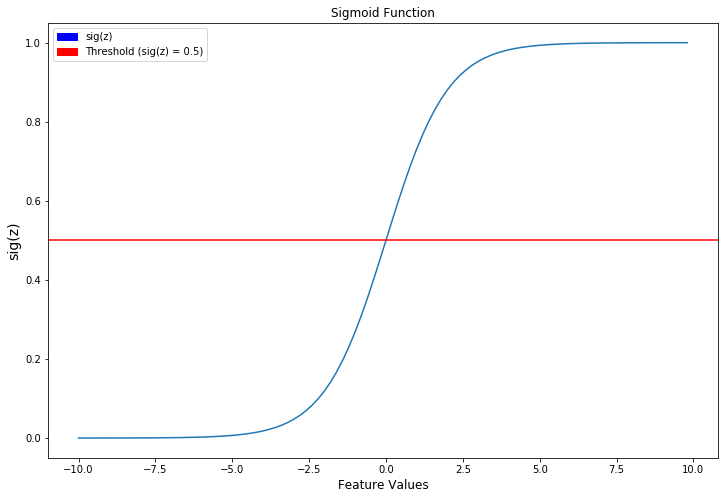

In [35]:
import math
import matplotlib.patches as mpatches 

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

plt.plot(x,sig)
plt.axhline(y=0.5, xmin=-10, xmax=10, hold=None,color = 'red')
ax.set(title='Sigmoid Function')
plt.xlabel('Feature Values',fontsize = 12)
plt.ylabel('sig(z)',fontsize = 14)
blue_patch = mpatches.Patch(color='blue', label='sig(z)')
red_patch = mpatches.Patch(color='red', label='Threshold (sig(z) = 0.5)')
plt.legend(handles=[blue_patch,red_patch])
plt.show()

In [36]:
X_train.shape[0]

3165